# UIUC Solar Power with Echo State Networks

This notebook uses an Echo State Network(ESN) (from ``pyESN``) to predict
the electricity produced by the solar farm at the University of Illinois.
All predictions in this notebook are optimized for 72 hour predictions. The
parameters will not generalize well to other prediction lengths because they
are optimized by looking at the mean squared error over the entire prediction
window.
In the future, the specific reactor design will motivate the size of the prediction
window.


The following items are included:
1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

### 1. Initial Demonstration

In [2]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from pyESN.pyESN import ESN

In [3]:
# import demand data
dataframe = pd.read_csv("data/solarfarm_data.csv", usecols=['time','power_data'])
solarpower = np.array(dataframe.power_data).astype('float64')

# normalize
norm = np.linalg.norm(solarpower)
solarpower_norm = solarpower/norm

In [4]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':None, 
          'trainlen':8000}

In [5]:
futureTotal = params['future']
time_range = np.array(dataframe.time)
hour_range = np.arange(0, len(time_range), 1)

In [6]:
tic = time.perf_counter()

init_pred = esn_prediction(solarpower_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 12.54 seconds
This simulation took 0.21 minutes


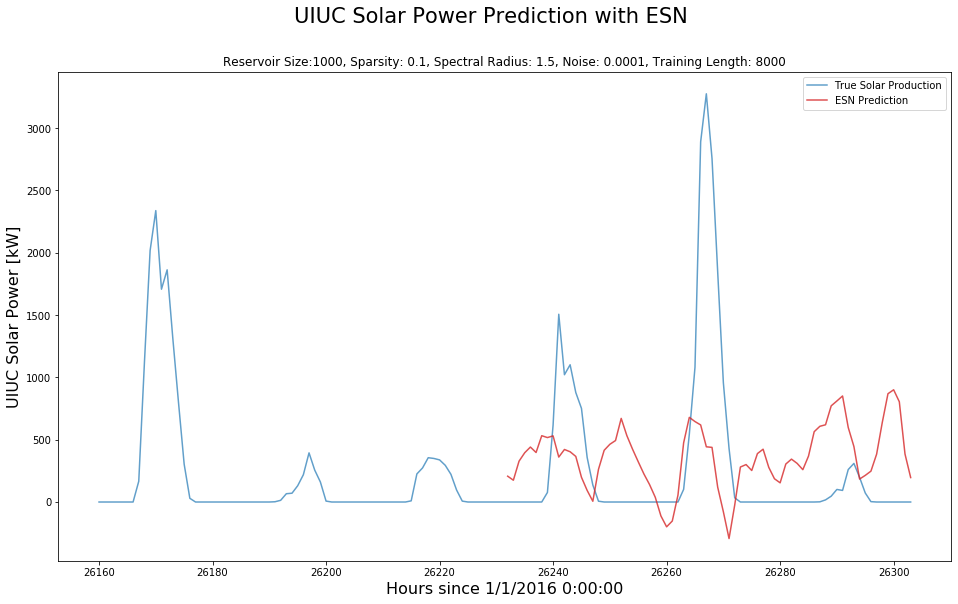

In [8]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Solar Power [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.004557388514435138
rho = 0.5, noise = 0.0003, MSE=0.0039768289644923965
rho = 0.5, noise = 0.0007, MSE=0.003609839854449636
rho = 0.5, noise = 0.001, MSE=0.003552339609877848
rho = 0.5, noise = 0.003, MSE=0.0035249543714466368
rho = 0.5, noise = 0.005, MSE=0.0035682810933069958
rho = 0.5, noise = 0.007, MSE=0.0036264317148004374
rho = 0.5, noise = 0.01, MSE=0.0037113220293370055
rho = 0.7, noise = 0.0001, MSE=0.004096183561752139
rho = 0.7, noise = 0.0003, MSE=0.0038277950817576156
rho = 0.7, noise = 0.0007, MSE=0.003465769321832191
rho = 0.7, noise = 0.001, MSE=0.0033987992300397855
rho = 0.7, noise = 0.003, MSE=0.0033812439470129593
rho = 0.7, noise = 0.005, MSE=0.003414689398542663
rho = 0.7, noise = 0.007, MSE=0.0034533108076694368
rho = 0.7, noise = 0.01, MSE=0.0035182336522189307
rho = 0.9, noise = 0.0001, MSE=0.0031829795090042275
rho = 0.9, noise = 0.0003, MSE=0.0034023608565772723
rho = 0.9, noise = 0.0007, MSE

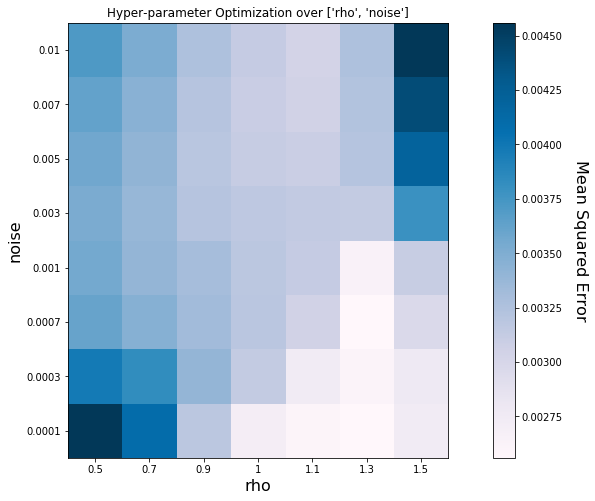

In [9]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(solarpower_norm,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

In [10]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.3 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.003005971657759844
n_reservoir = 600, sparsity = 0.01, MSE=0.0027321563170109604
n_reservoir = 600, sparsity = 0.03, MSE=0.0028190528288102074
n_reservoir = 600, sparsity = 0.05, MSE=0.002958263517391476
n_reservoir = 600, sparsity = 0.1, MSE=0.0027769739831787514
n_reservoir = 600, sparsity = 0.15, MSE=0.0028467876661778255
n_reservoir = 600, sparsity = 0.2, MSE=0.0025667162760728665
n_reservoir = 800, sparsity = 0.005, MSE=0.0031653464838206167
n_reservoir = 800, sparsity = 0.01, MSE=0.003162105747805453
n_reservoir = 800, sparsity = 0.03, MSE=0.002490262168573343
n_reservoir = 800, sparsity = 0.05, MSE=0.002781914935269743
n_reservoir = 800, sparsity = 0.1, MSE=0.0029082777050701116
n_reservoir = 800, sparsity = 0.15, MSE=0.002547161237673031
n_reservoir = 800, sparsity = 0.2, MSE=0.002999214886803622
n_reservoir = 1000, sparsity = 0.005, MSE=0.0020282912950792525
n_reservoir = 1000, sparsity = 0

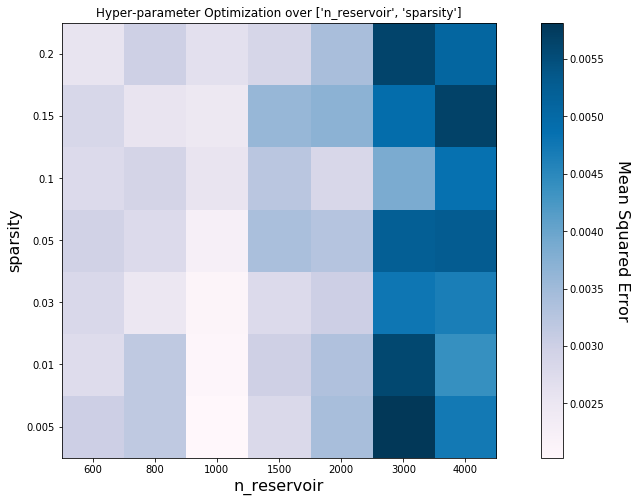

In [11]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(solarpower_norm,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)
        
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02} seconds.")
print(f"This simulation took {elapsed/60:0.02} minutes.")

In [12]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 1000 
sparsity = 0.005


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 4000, MSE=0.00325060867317511
trainlen = 4300, MSE=0.002579700152444875
trainlen = 4600, MSE=0.002855110528129992
trainlen = 4900, MSE=0.0028972038791680115
trainlen = 5200, MSE=0.0025797041531163242
trainlen = 5500, MSE=0.0028314538791164782
trainlen = 5800, MSE=0.0023683355649062334
trainlen = 6100, MSE=0.0026944452024591932
trainlen = 6400, MSE=0.002856944948692006
trainlen = 6700, MSE=0.002174611932041886
trainlen = 7000, MSE=0.002821512485882354
trainlen = 7300, MSE=0.00352996725206435
trainlen = 7600, MSE=0.0026232132676348857
trainlen = 7900, MSE=0.00242705955562024
trainlen = 8200, MSE=0.0034175033212972515
trainlen = 8500, MSE=0.0033527419133601035
trainlen = 8800, MSE=0.0019766141197294714
trainlen = 9100, MSE=0.0024491276252529876
trainlen = 9400, MSE=0.0033553384371581723
trainlen = 9700, MSE=0.002425632930512432
trainlen = 10000, MSE=0.002658026467196487
trainlen = 10300, MSE=0.0022939228110000795
trainlen = 10600, MSE=0.00266119454

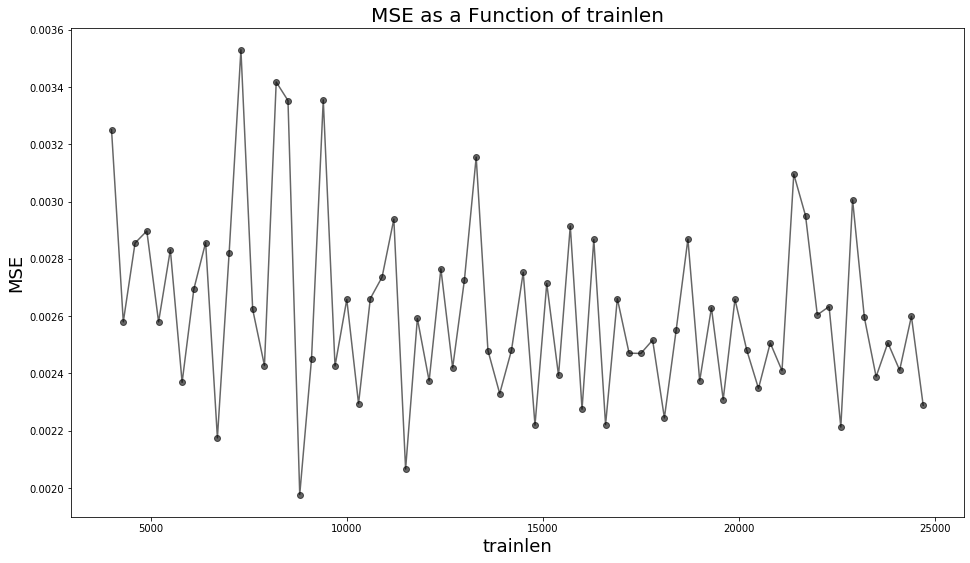

In [13]:
tic = time.perf_counter()
trainingLengths = np.arange(4000,25000,300)
trainlen_loss = grid_optimizer(solarpower_norm,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

In [16]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 8800


### 5. Final Optimized ESN

In [17]:
tic = time.perf_counter()

opt_pred = esn_prediction(solarpower_norm, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 16.28 seconds
This simulation took 0.27 minutes


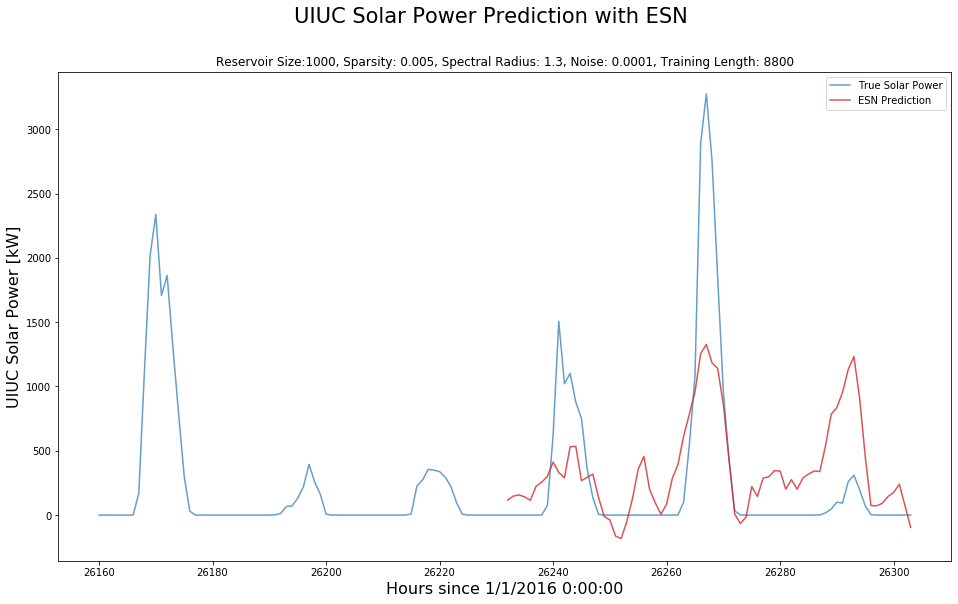

In [18]:
time_range = np.arange(0,len(solarpower),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Solar Power [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()